In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.patches as patches
# from typing import Dict, Set, List

In [4]:
from utils.metrics import compute_discernability_and_cavg
from utils.preprocessing import filter_by_h3_hexagons

# Data preparation

In [5]:
df_gps = pd.read_csv("data/processed_trips.csv")

df_people = pd.read_csv("data/individuals_dataset.csv")
df_people = df_people[df_people['GPS_RECORD'] == True]

df_merged = pd.merge(
    df_gps,
    df_people[['ID', 'WEIGHT_INDIV']],
    left_on='ID',
    right_on='ID',
    how='inner'
)#.drop(columns='ID')
df_merged = df_merged.rename(columns={"ori_lat": "start_lat", "ori_lon": "start_lon", "dst_lat":'end_lat',"dst_lon":'end_lon'})

In [6]:
df_merged.head()

,start_time,start_lat,start_lon,end_time,end_lat,end_lon,ID,WEIGHT_INDIV
0,2022-12-12 06:55:01,48.607980,2.304657,2022-12-12 06:59:59,48.607980,2.304657,50_1587,2280.44954
1,2022-12-12 07:03:01,48.607980,2.304657,2022-12-12 07:27:00,48.612165,2.304178,50_1587,2280.44954
2,2022-12-12 07:56:01,48.610726,2.306309,2022-12-12 08:24:59,48.631089,2.437251,50_1587,2280.44954
3,2022-12-12 17:10:00,48.630281,2.436163,2022-12-12 17:30:00,48.612855,2.347746,50_1587,2280.44954
4,2022-12-12 17:35:00,48.609469,2.312745,2022-12-12 17:40:00,48.609469,2.312745,50_1587,2280.44954


In [7]:
# List of paris area hexagons (resolution 6)
target_hexagons = [
    "861fb4667ffffff",
    "861fb4677ffffff", 
    "861fb466fffffff",
    "861fb4647ffffff",
    "861fb475fffffff"
]

In [8]:
#Keep only trips in paris area hexagons
df_filtered = filter_by_h3_hexagons(df_merged, target_hexagons)
df_filtered.drop(columns=['ori_h3', 'dst_h3'], inplace=True)

In [9]:
# some fields are categorical and will require special treatment
categorical = set((
    'ID',
    'start_time',
    'end_time',
))

# Mondrian Algorithm

In [10]:
# Compute the span: the difference between the maximum and the minimum values of a column
# Per la colonna utm_north: Valore massimo: 130, Valore minimo: 100, Intervallo (span): 130 − 100 = 30
def getSpans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [11]:
# example: "span" of the whole dataset
fullSpans = getSpans(df_filtered, df_filtered.index)
fullSpans

{'start_time': 27440,
 'start_lat': 0.13232293237486914,
 'start_lon': 0.2410849708364986,
 'end_time': 27503,
 'end_lat': 0.13232263095691366,
 'end_lon': 0.24203178745904674,
 'ID': 2166,
 'WEIGHT_INDIV': 19374.77717876}

In [12]:
# Splits a given partition of the dataframe along a specific column. 
# It finds the median of the column and divides the data into two sub-partitions: 
# left (values less than the median) and right (values greater than or equal to the median).

def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [13]:
# in this case, only consider number of data in each partition
def isKAnonymous(df, partition, sensitiveColumn, k=10):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitiveColumn: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    else:
        return True

In [14]:
#split dataset to partitions to achieve k-anonymity, here "isValid" refers to "isKAnonymous"
def partitionDataset(df, featureColumns, sensitiveColumn, scale, isValid):
    """
    :param               df: The dataframe to be partitioned.
    :param  featureColumns: A list of column names along which to partition the dataset.
    :param sensitiveColumn: The name of the sensitive column (to be passed on to the `isValid` function)
    :param            scale: The column spans as generated before.
    :param         isValid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finishedPartitions = [] # Contains partitions that comply with k-anonymity
    partitions = [df.index] # Initially, the entire dataset is a partition

    # Continue partitioning until there are no partitions left to verify.
    while partitions:
        partition = partitions.pop(0) # Extract a partition to analyze
        spans = getSpans(df[featureColumns], partition, scale)
        # Sort the spans from largest to smallest
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            # Split the partition on the column with the widest span
            lp, rp = split(df, partition, column)
            if not isValid(df, lp, sensitiveColumn) or not isValid(df, rp, sensitiveColumn):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finishedPartitions.append(partition)
    return finishedPartitions

In [15]:
#we apply our partitioning method to four columns of our dataset, using "ID" as the sensitive attribute
featureColumns = ['start_lon', 'start_lat', 'end_lon', 'end_lat']
sensitiveColumn = 'ID'
finishedPartitions = partitionDataset(df_merged, featureColumns, sensitiveColumn, fullSpans, isKAnonymous)

In [16]:
# check how many partitions we got
len(finishedPartitions)

6721

In [17]:
def getCoords(df, column, partition, offset=0.1):
    
    sv = df[column][partition].sort_values()
    nextValue = sv[sv.index[-1]]
    largerValues = df[df[column] > nextValue][column]
    if len(largerValues) > 0:
        next_value = largerValues.min()
    l = sv[sv.index[0]]
    r = nextValue

    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def getPartitionRects(df, partitions, columnX, columnY, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = getCoords(df, columnX, partition, offset=offsets[0])
        yl, yr = getCoords(df, columnY, partition, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def getBounds(df, column, offset=1.0):
    return df[column].min()-offset, df[column].max()+offset

In [18]:
# we calculate the bounding rects of all partitions that we created
columnX, columnY = featureColumns[:2]
rects = getPartitionRects(df_merged, finishedPartitions, columnX, columnY, offsets=[0.0, 0.0])

In [19]:
def plotRects(df, ax, rects, columnX, columnY, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl), xr-xl, yr-yl, linewidth=1, edgecolor=edgecolor, facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*getBounds(df, columnX))
    ax.set_ylim(*getBounds(df, columnY))
    ax.set_xlabel(columnX)
    ax.set_ylabel(columnY)

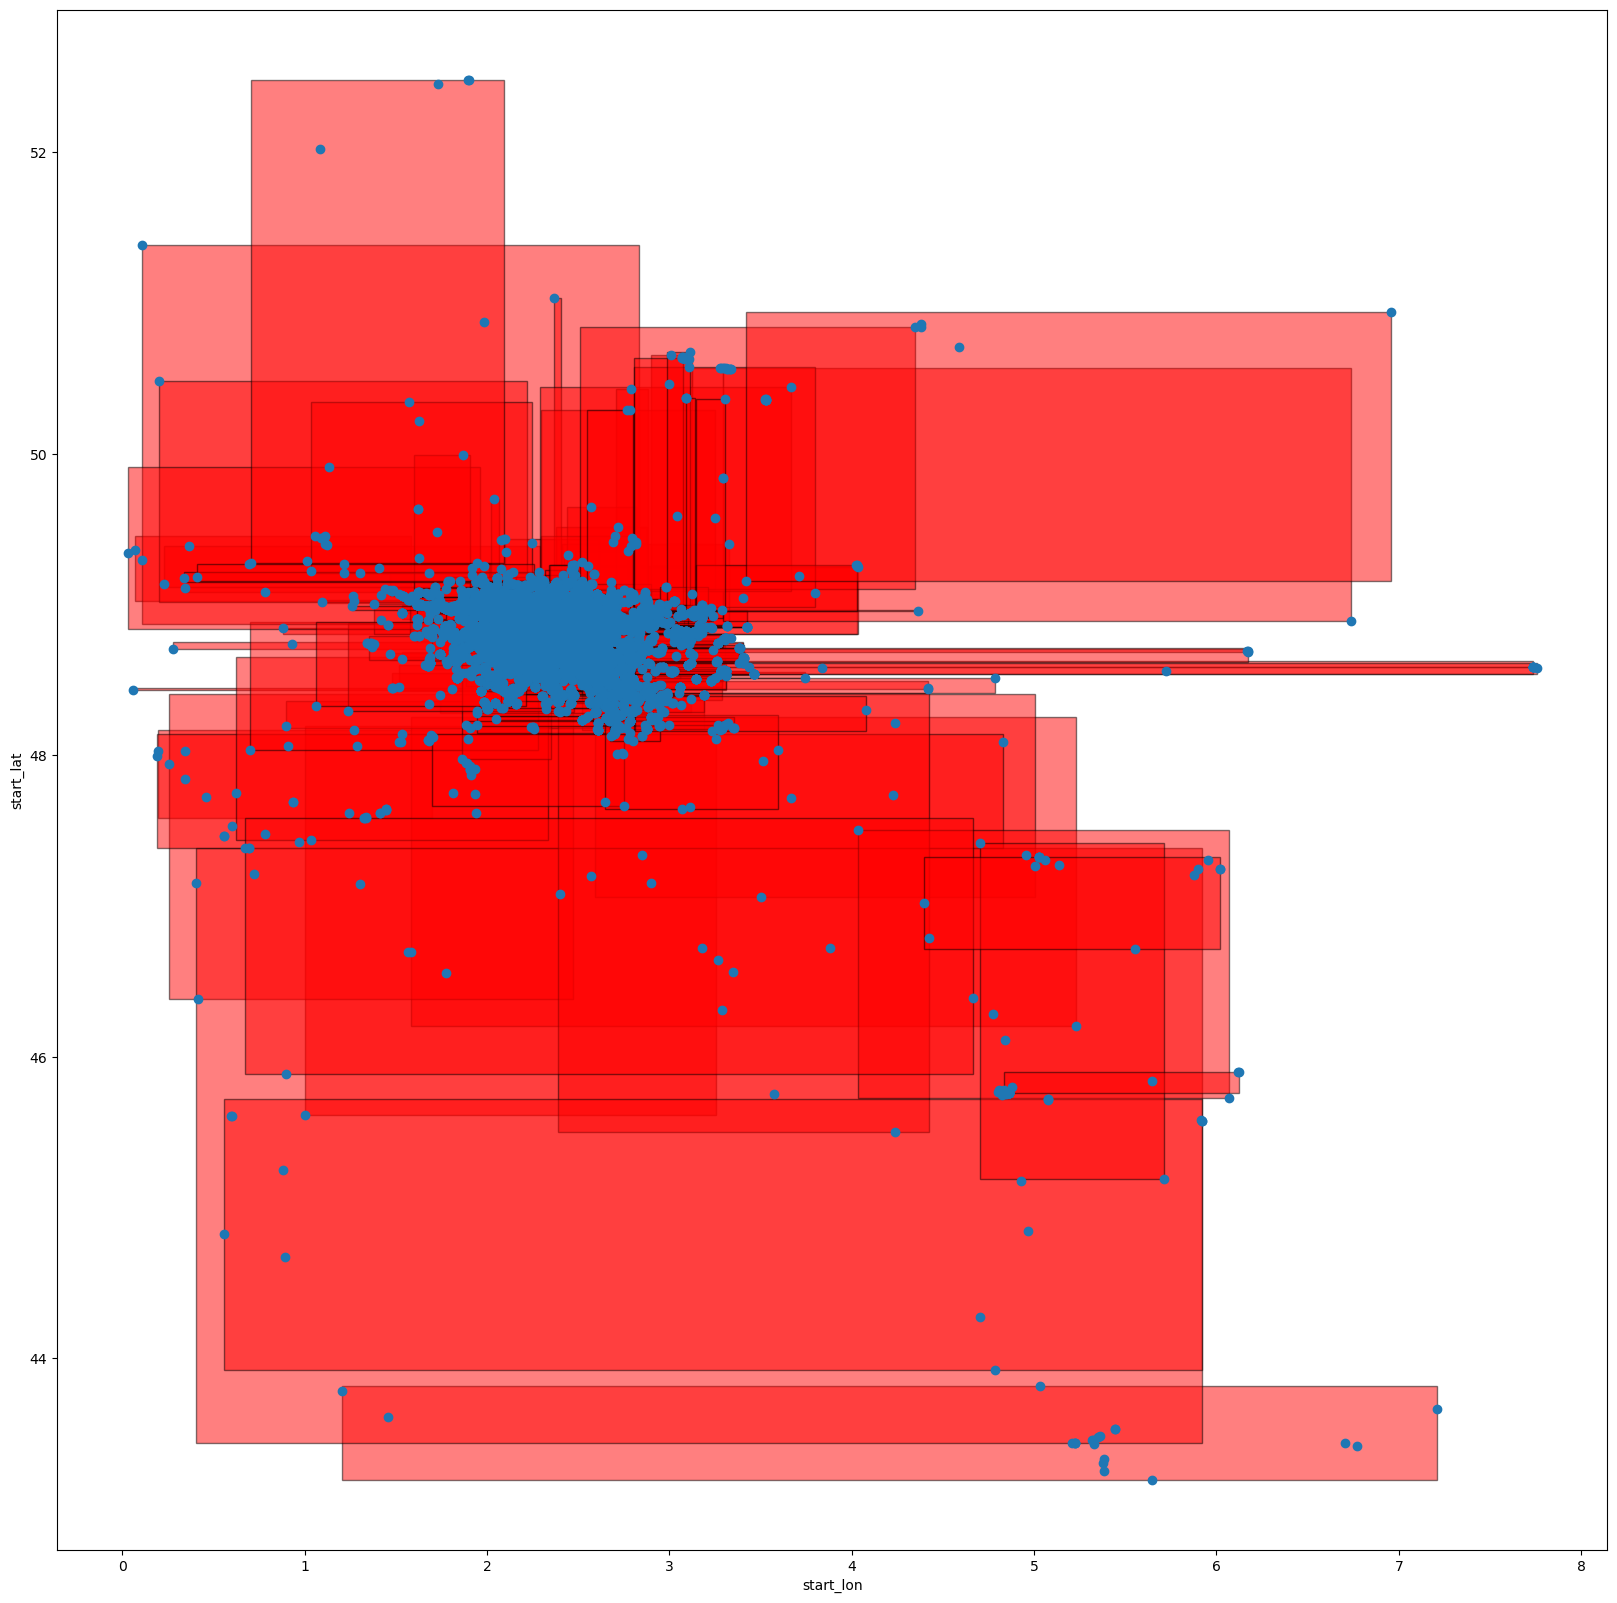

In [20]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plotRects(df_merged, ax, rects, columnX, columnY, facecolor='r')
pl.scatter(df_merged[columnX], df_merged[columnY])

x_min, x_max = df_merged[columnX].min(), df_merged[columnX].max()
y_min, y_max = df_merged[columnY].min(), df_merged[columnY].max()
margin_x = (x_max - x_min) * 0.05  
margin_y = (y_max - y_min) * 0.05

ax.set_xlim(x_min - margin_x, x_max + margin_x)
ax.set_ylim(y_min - margin_y, y_max + margin_y)

pl.show()

In [21]:
def aggNumericalColumn(series):
    return series.median()

In [22]:
def buildAnonymizedDataset(df, partitions, featureColumns, sensitiveColumn, maxPartitions=None):
    aggregations = {}
    # For each numeric column in featureColumns, specify the type of aggregation to apply (by default anonymization using median).
    for column in featureColumns:
        aggregations[column] = aggNumericalColumn

    df_with_partitions = df.copy()
    df_with_partitions['partition_id'] = -1  # Initialize all  with -1 (no partition yet)
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if maxPartitions is not None and i > maxPartitions:
            break
        df_with_partitions.loc[partition, 'partition_id'] = i
        # Aggregate data only for indexes in the current partition.
        groupedColumns = df.loc[partition].agg(aggregations, squeeze=False)
        # Count how many times each value in the sensitive column appears within the partition.
        sensitiveCounts = df.loc[partition].groupby(sensitiveColumn, observed=True).agg({sensitiveColumn : 'count'})
        groupedColumnsDf = groupedColumns.to_frame()
        groupedColumns = pd.DataFrame(groupedColumnsDf.values.T, columns=groupedColumnsDf.index)
        values = groupedColumns.iloc[0].to_dict()
        values['partition_id'] = i
        for sensitiveValue, count in sensitiveCounts[sensitiveColumn].items():
            if count == 0:
                continue
            values.update({
                sensitiveColumn : sensitiveValue,
                'count' : count,
            })
            rows.append(values.copy())
    anonymized_df = pd.DataFrame(rows)
    return anonymized_df, df_with_partitions

In [23]:
df_anon, df_with_partitions = buildAnonymizedDataset(df_merged, finishedPartitions, featureColumns, sensitiveColumn)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...
Finished 1601 partitions...
Finished 1701 partitions...
Finished 1801 partitions...
Finished 1901 partitions...
Finished 2001 partitions...
Finished 2101 partitions...
Finished 2201 partitions...
Finished 2301 partitions...
Finished 2401 partitions...
Finished 2501 partitions...
Finished 2601 partitions...
Finished 2701 partitions...
Finished 2801 partitions...
Finished 2901 partitions...
Finished 3001 partitions...
Finished 3101 partitions...
Finished 3201 partitions...
Finished 3301 partitions...
Finished 3401 partitions...
Finished 3501 partitions...
Fini

In [24]:
df_anon.head()

,start_lon,start_lat,end_lon,end_lat,partition_id,ID,count
0,2.368335,48.851813,2.369312,48.85179,0,14_3594,1
1,2.368335,48.851813,2.369312,48.85179,0,16_3915,1
2,2.368335,48.851813,2.369312,48.85179,0,16_3963,2
3,2.368335,48.851813,2.369312,48.85179,0,42_0461,1
4,2.368335,48.851813,2.369312,48.85179,0,42_0559,1


In [25]:
metrics = compute_discernability_and_cavg(df_anon, k=10)
print(f"C_DM: {metrics['C_DM']:,}")
print(f"C_AVG: {metrics['C_AVG']:.4f}")

C_DM: 17,447
C_AVG: 0.1556


In [26]:
metrics

{'C_DM': np.int64(17447),
 'C_AVG': np.float64(0.15555406724200616),
 'total_records': np.int64(81291),
 'total_equivalence_classes': 52259,
 'k': 10}